In [2]:
import numpy as np
import pandas as pd
url = 'https://projects.fivethirtyeight.com/soccer-api/club/spi_matches.csv'
df = pd.read_csv(url, parse_dates=['date']).dropna()
df = df[(df.league=='Barclays Premier League') & (df.season <= 2019)].reset_index(drop=True)
df['margin'] = np.abs(df['score1'] - df['score2'])
df['home_margin'] = df['score1'] - df['score2']
results = []
for result in df['home_margin']:
    if result > 0:
        results.append("Home Win")
    elif result < 0:
        results.append("Away Win")
    else:
        results.append("Draw")
results = pd.Series(results).to_frame().rename(columns={0:'result'}).reset_index(drop=True)
df = pd.concat([df, results], axis=1)

In [3]:
def ECDF(data):
    n = len(data)
    X = np.sort(data)
    y = np.arange(1, (n)+1) / n
    return X, y

In [4]:
X, y = ECDF(df['score1'])
X_spi, y_spi = ECDF(df['spi1'])

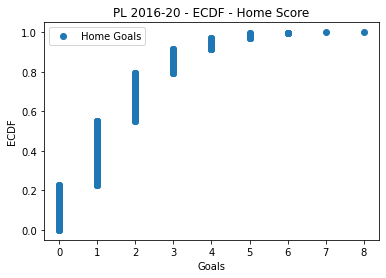

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(X, y, marker='o', linestyle='none', label="Home Goals")
plt.xlabel("Goals")
plt.ylabel("ECDF")
plt.title("PL 2016-20 - ECDF - Home Score")
plt.legend()
plt.show()

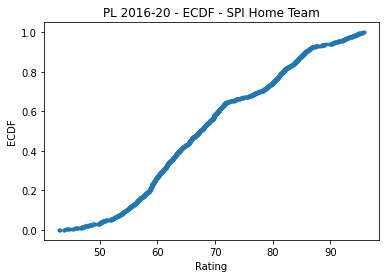

In [6]:
plt.plot(X_spi, y_spi, marker=".", linestyle='none', label='Home SPI')
plt.title("PL 2016-20 - ECDF - SPI Home Team")
plt.xlabel("Rating")
plt.ylabel("ECDF")
plt.show()

In [7]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from CTN import CN, CTN
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Team Categorical to Numerical Conversion
t1 = CN(df,"team1")
t2 = CN(df,"team2")
team1 = CTN(df,4,5,t1)
team2 = CTN(df,5,6,t2)

# Bringing it all together
X_num = df[['spi1', 'spi2', 'prob1', 'prob2', 'probtie', 'proj_score1', 'proj_score2', 'importance1', 'importance2', 'score1', 'score2', 'xg1', 'xg2', 'nsxg1', 'nsxg2', 'adj_score1', 'adj_score2', 'margin', 'home_margin']].reset_index(drop=True)
X_final = pd.concat([team1, team2, X_num], axis=1)
y_final = df[['result']].copy()
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.375, random_state=6)

# Model evaluation
models = []
models.append(('BNB:', BernoulliNB()))
models.append(('GNB:', GaussianNB()))
models.append(('DTC:', DecisionTreeClassifier()))
models.append(('ETC:', ExtraTreesClassifier()))
models.append(('RFC:', RandomForestClassifier()))
models.append(('LR:', LogisticRegression(solver='liblinear', multi_class='ovr')))
names = []
results = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=6, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train.values.ravel(), cv=kfold, scoring='accuracy')
    names.append(name)
    results.append(cv_results)
    print("%s %f (%f)" % (name, cv_results.mean(), cv_results.std()))

BNB: 1.000000 (0.000000)
GNB: 0.755832 (0.039054)
DTC: 1.000000 (0.000000)
ETC: 1.000000 (0.000000)
RFC: 1.000000 (0.000000)
LR: 1.000000 (0.000000)


In [8]:
model = RandomForestClassifier(n_estimators=400, random_state=6).fit(X_train, y_train.values.ravel())
y_test_predictions = model.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test_predictions, y_test))
print("Classification Report:", classification_report(y_test_predictions, y_test))
print("Confusion Matrix:", confusion_matrix(y_test_predictions, y_test))

Accuracy Score: 1.0
Classification Report:               precision    recall  f1-score   support

    Away Win       1.00      1.00      1.00       168
        Draw       1.00      1.00      1.00       128
    Home Win       1.00      1.00      1.00       261

    accuracy                           1.00       557
   macro avg       1.00      1.00      1.00       557
weighted avg       1.00      1.00      1.00       557

Confusion Matrix: [[168   0   0]
 [  0 128   0]
 [  0   0 261]]


In [9]:
from PvA import PvA
PvA = PvA(y_test_predictions, y_test)

In [10]:
PvA

,Predicted,Actual
0,Draw,Draw
1,Away Win,Away Win
2,Draw,Draw
3,Home Win,Home Win
4,Draw,Draw
...,...,...
552,Home Win,Home Win
553,Away Win,Away Win
554,Draw,Draw
555,Draw,Draw
